# Discretizando la ecuación de conducción de calor

Se tiene la ecuación de calor en el estado no estacionario:

$$\frac{1}{\alpha}\frac{\partial T}{\partial t}=\frac{\partial^2 T}{\partial r^2}+\frac{2}{r}\frac{\partial T}{\partial r}$$


Para proceder con la discretización se debe elegir qué derivada numérica se va a utilizar, para esto se recurre a la página 668 del libro de métodos numéricos Chapra, donde se describe una serie de aproximaciones a las derivadas, por ejemplo, si se toma una diferencia hacia adelante con un error $O(h^2)$:

$$\frac{\partial T}{\partial t}\approx\frac{T_{i}^{l+1}-T_{i}^{l}}{\Delta t}$$

Mientras que si se toma una diferencia centrada para con un error $O(h^2)$ para la dimensión espacial:

$$\frac{\partial T}{\partial r}\approx\frac{T_{i+1}^{l}-T_{i-1}^{l}}{2\Delta r}$$
$$\frac{\partial^2 T}{\partial r^2}\approx\frac{T_{i+1}^{l}-2T_{i}^{l}+T_{i-1}^{l}}{\left(\Delta r\right)^2}$$

Sustituyendo y aproximando $r\approx i\Delta r$:

$$\frac{1}{\alpha}\frac{T_{i}^{l+1}-T_{i}^{l}}{\Delta t}=\frac{T_{i+1}^{l}-2T_{i}^{l}+T_{i-1}^{l}}{\left(\Delta r\right)^2}+\frac{2}{i\Delta r}\frac{T_{i+1}^{l}-T_{i-1}^{l}}{2\Delta r}$$

Entonces, despejando para $T_{i}^{l+1}$:

$$T_{i}^{l+1}=T_{i}^{l}+\frac{\alpha\Delta t}{\left(\Delta r\right)^2}\left[T_{i+1}^l-2T_{i}^l+T_{i-1}^l+\frac{1}{i}\left(T_{i+1}^l-T_{i-1}^l\right)\right]$$


## Coeficiente de difusividad térmica de la papa ($\alpha$)

El coeficiente de difusividad térmica de la papa ronda entre los valores de los $1.33\times 10^{-7} \ \frac{m^2}{s}$ y $1.46\times 10^{-7} \ \frac{m^2}{s}$. (Solano-Cornejo, M. A., Vidaurre-Ruiz, J. M., 2017).

Por lo tanto, para fines de este proyecto, se tomará el promedio del rango de los valores para el coeficiente de difusividad térmica para la papa, el cual estará dado por:

$$\alpha = \frac{1.33\times 10^{-7} + 1.46\times 10^{-7}}{2}=1.4\times 10^{-7} \ \frac{m^2}{s}$$

Para la concordancia de dimensionalidades del calculo en el código, hacemos la conversión de $\frac{m^2}{s}$ a $\frac{cm^2}{s}$:

$$\alpha = 1.4\times 10^{-7} \ \frac{m^2}{s}\left(\frac{1 \ cm}{10^{-2} \ m}\right)^2 = 1.4\times 10^{-3} \ \frac{cm^2}{s}$$

En conclusión, el valor para $\alpha$ es de $1.4\times 10^{-3} \ \frac{cm^2}{s}$, en el código $\alpha$ se representará con "D".

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from copy import deepcopy

# Condiciones iniciales y de contorno

## Condiciones de iniciales

Al inicio, la temperatura en la superficie se toma como la temperatura en el horno, ignorando los efectos de la convección, es una aproximación que puede ser gruesa; sin embargo, la estimación de la temperatura superficial podría conllevar un esfuerzo analítico mayor y para estimar el valor del tiempo en que el centro de la papa alcanza la temperatura de $100$ °C se realizará una parametrización polinómica que permita estimar $T(r,t)$ que se hace más sencillo si se no se toma en cuenta la variación temporal de la temperatura superficial.

## Condiciones de contorno

1. $T(R,t)=T_{s}$, esto sería la temperatura cuando $r=R=2.5$ cm, $T_{s}$ necesariamente deberá ser conocido y se tomará a partir de la consideración de la convección.
2. $T_{\infty}=T_{h}=220$ °C, es la temperatura constante del horno.
3. $T(0,t)=T_{i}(t)$, es la temperatura en el interior de la esfera.
4. $T(r,\infty)=T_{\infty}$, temperatura en toda la papa esfera se iguala a la temperatura del horno cuando $t\rightarrow \infty$.

### Convección

Para tomar en cuenta la convección, se parte de la ecuación de convección:

$$\frac{dQ}{dt}=hA\left(T_{\infty}-T_{s}\right)$$

Recordando la definición de capacidad calorífica, se toma que $dQ=mc_p dT$, entonces:

$$\frac{dT}{dt}=\frac{hA}{mc_p}\left(T_{\infty}-T_{s}\right)$$

Donde entonces, se puede discretizar tomando una diferencia hacia adelante con un error de $O(h^2)$, y despejando:

$$T_{R}^{l+1}=T_{R}^{l}+\frac{hA}{mc_p}\left(T_{\infty}-T_{s}\right)\Delta t$$

$m$ se determina a partir del volumen y densidad de la papa. Los parámetros $h$, $c_p$, $rho$ (densidad de la papa), se seleccionarán según se considere, para evitar que haya errores de _overflow_ durante el cálculo.

- Otro factor importante es el coeficiente convectivo, que se tomó a conveniencia de http://help.solidworks.com/2011/spanish/SolidWorks/cworks/LegacyHelp/Simulation/AnalysisBackground/ThermalAnalysis/Convection_Topics/Convection_Heat_Coefficient.htm.
- El valor empleado para la capacidad calorífica, se tomó de https://www.engineeringtoolbox.com/specific-heat-capacity-food-d_295.html.
- El valor empleado para la densidad se tomó de https://www.aqua-calc.com/page/density-table/substance/potatoes-coma-and-blank-russet-coma-and-blank-flesh-blank-and-blank-skin-coma-and-blank-raw-blank--op-includes-blank-foods-blank-for-blank-usda-quote-s-blank-food-blank-distribution-blank-program-cp--blank--op-diced-cp-.

In [2]:
Lx = 2.50 # radio papa, cm
dx = 0.06 # delta r, cm
D = 1.4e-3 # coeficiente de difusividad, cm^2/s
x = np.arange(0,Lx+dx,dx) # arreglo para r

dt = 1 # delta t, s
tf = 4000 # tiempo final, s
t = np.arange(0,tf+dt,dt) # arreglo para t
T,X = np.meshgrid(t,x)

rho=0.63401e-3 # kg/cm^3
M=rho*(4*np.pi*Lx**3/3) # kg
C=3645 # J/(kg*K)
h=0.0005 # W/(cm^2*K)
A=4*np.pi*Lx**2

In [3]:
# matriz inicial
rhoi = 25*np.ones((len(t),len(x)),float)

# condiciones iniciales
for n in range(len(x)):
    rhoi[0,n] = 25

# condiciones de frontera    
for m in range(len(t)-1):
    rhoi[m,0]=25
    rhoi[m+1,-1]=rhoi[m,-1]+h*A*(220-rhoi[m,-1])*dt/(M*C)

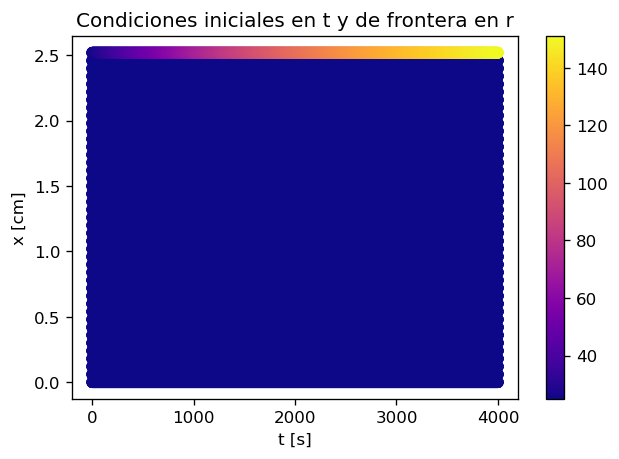

In [4]:
plt.figure(dpi=120)
plt.scatter(T,X,c=rhoi.T,cmap="plasma")
plt.title('Condiciones iniciales en t y de frontera en r')
plt.xlabel('t [s]')
plt.ylabel('x [cm]')
plt.colorbar()
plt.show()

# Solución

Se ejecuta el algoritmo que itera en el tiempo y el espacio para las posiciones en la matriz:

$$T_{i}^{l+1}=T_{i}^{l}+\frac{\alpha\Delta t}{\left(\Delta r\right)^2}\left[T_{i+1}^l-2T_{i}^l+T_{i-1}^l+\frac{1}{i}\left(T_{i+1}^l-T_{i-1}^l\right)\right]$$

De forma que se logra resolver para todo el espacio y el tiempo, conservando las condiciones de contorno para la superficie y el valor de $r=0$, puesto que en esta posición se indefine la solución.

In [5]:
def DiferenciasFinitasCalor(rhoi):
    '''
    Función que calcula el flujo de calor con el método de diferencias finitas
    
    Parámetros iniciales:
    ---------------------
    rhoi: matriz sobre la que se itera, contiene las condiciones iniciales
    niter: número de iteraciones
    
    Salida:
    ---------------------
    rho: matriz con los valores de rho.
    '''
    rho = deepcopy(rhoi)
    alpha = D*dt/dx**2 # coeficiente de difusividad adimensional
    t100=0
#     for iter in range(niter):
    for m in range(len(t)-1):
        for n in range(1,(len(x)-1)):
            rho[m+1,1]=rho[m,2] # se actualiza la posición con el de n=1, con el valor pasado de n=2, esto corrige un error
            rho[m+1,0]=rho[m,1] # se actualiza la posición de n=0, con el valor pasado de n=1, esto corrige un error
            rho[m+1,n] = rho[m,n] + alpha*(rho[m,n-1] - 2*rho[m,n] + rho[m,n+1]+(rho[m,n+1]-rho[m,n-1])/n)
            if -dx<=x[n]<=dx:# se busca el valor más cercano a r=0 cm
                if 100.5>=rho[m,n]>=99.5: # se escoge una temperatura que sea más o menos 100 celsius
                    t100=(m,n)
    return rho,t100

In [6]:
RhoDF,t100=DiferenciasFinitasCalor(rhoi)

In [7]:
print("En el tiempo",t100[0],"s, se alcanza una temperatura de",RhoDF[t100[0],t100[1]],"°C")

En el tiempo 2667 s, se alcanza una temperatura de 100.47566121064035 °C


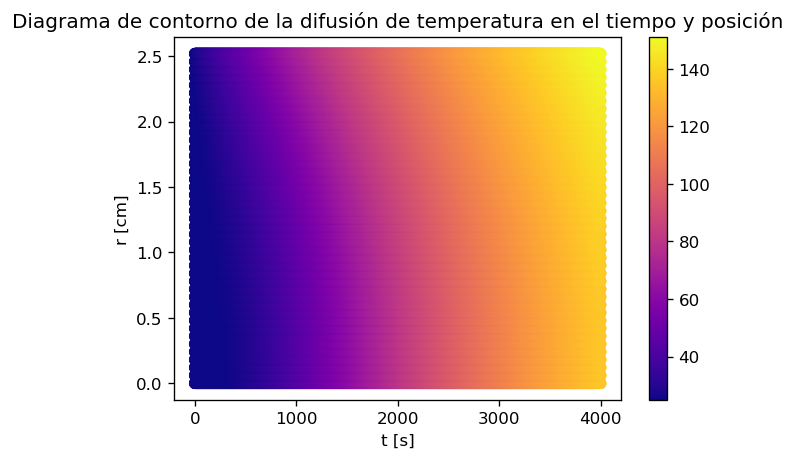

In [8]:
plt.figure(dpi=120)
plt.scatter(T,X,c=RhoDF.T,cmap='plasma')
plt.ylabel('r [cm]')
plt.xlabel('t [s]')
plt.title('Diagrama de contorno de la difusión de temperatura en el tiempo y posición')
plt.colorbar()
plt.show()

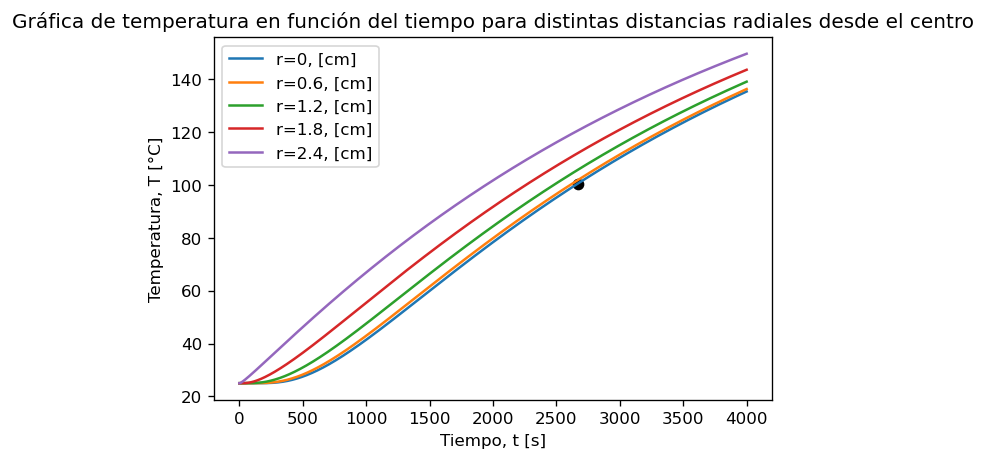

In [9]:
plt.figure(dpi=120)
plt.plot(t,RhoDF[:,0])
plt.plot(t,RhoDF[:,10])
plt.plot(t,RhoDF[:,20])
plt.plot(t,RhoDF[:,30])
plt.plot(t,RhoDF[:,40])
plt.scatter(t[t100[0]],RhoDF[t100[0],t100[1]],color="black")
plt.xlabel('Tiempo, t [s]')
plt.ylabel('Temperatura, T [°C]')
plt.title('Gráfica de temperatura en función del tiempo para distintas distancias radiales desde el centro')
plt.legend(['r=0, [cm]','r=0.6, [cm]','r=1.2, [cm]','r=1.8, [cm]','r=2.4, [cm]'])
plt.show()

# Conclusión y Análisis de resultados

- El tiempo en el que la temperatura en el centro de la papa alcanza los $100$ °C es en aproximadamente al menos $2667$ segundos, o $44$ minutos con $27$ segundos.

- Pensando en que el coeficiente de difusividad es del orden de $10^{-3}$, es esperable que la conductividad ocurra de manera lenta, a pesar de que la distancia radial que debe recorrer no es mucha, entonces cuatro minutos parece ser un tiempo razonable; sin embargo, debería tomarse en cuenta que se partió de una papa cuya superficie ya se encontraba a la temperatura del horno, entonces el tiempo real será mayor.

- El comportamiento observado para la temperatura en el tiempo es el esperado, pues las curvas son más abruptas para las distancias radiales mayores y más suaves para las distancias radiales menores, señal de que la transferencia de calor a lo largo del tiempo tarda más en alcanzar las distancias radiales menores.
- Sobre si las suposiciones hechas son razonables, es un tanto discutible. Se observó que si se buscaba realizar la solución desde -2.5 cm a 2.5 cm en r, se generaban problemas que hacían que la solución no tuviera sentido, pues la posición cercana al r=-2.5 cm se iba a temperaturas negativas. Sin embargo, el plantear esta solución de la forma en que se realizó permitió generar resultados que pueden percibirse como reales.